# Разработка решения по персонализации предложений постоянным клиентам

Заказчик этого исследования — интернет-магазин «В один клик». 
Руководство компании желает разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

**Цель исследования:**

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Ход исследования:**

1. Загрузка данных из датасета. Изучение на наличие пропусков, дубликатов и прочих аномалий.
2. На этапе предобработки я избавлюсь от части данных, негативно повлияющей на результаты исследования.
3. Проведу исследование по распределению количественных и категориальных признаков.
4. Объединю датасеты и проведу корреляционный анализ признаков.
5. Обучу модели МО с различными гиперпараметрами. Выберу наилучшую модель по выбранной метрике.
6. Проведу оценку важности входных признаков.
7. Выполню сегментацию покупателей.

## Загрузка данных

**Импортируем необходимые библиотеки.**

In [49]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

!pip install shap -q
import shap

**Откроем csv-файлы с данными и сохраним их в датафреймы.**

In [2]:
df_market = pd.read_csv('D:/Data_Sciense/Datasets/Train_with_teacher/market_file.csv')
df_market_money = pd.read_csv('D:/Data_Sciense/Datasets/Train_with_teacher/market_money.csv')
df_market_time = pd.read_csv('D:/Data_Sciense/Datasets/Train_with_teacher/market_time.csv')
df_money = pd.read_csv('D:/Data_Sciense/Datasets/Train_with_teacher/money.csv', sep=';', decimal = ',')

**Проведем знакомство с данными. Ознакомимся с содержанием `market_file.csv`:**

In [3]:
pd.set_option('display.max_columns', None)
df_market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Файл содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:**

* <b>id</b> — номер покупателя в корпоративной базе данных.
* <b>Покупательская активность</b> — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* <b>Тип сервиса</b> — уровень сервиса, например «премиум» и «стандарт».
* <b>Разрешить сообщать</b> — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* <b>Маркет_актив_6_мес</b> — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* <b>Маркет_актив_тек_мес</b> — количество маркетинговых коммуникаций в текущем месяце.
* <b>Длительность</b> — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* <b>Акционные_покупки</b> — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* <b>Популярная_категория</b> — самая популярная категория товаров у покупателя за последние 6 месяцев.
* <b>Средний_просмотр_категорий_за_визит</b> — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* <b>Неоплаченные_продукты_штук_квартал</b> — общее число неоплаченных товаров в корзине за последние 3 месяца.
* <b>Ошибка_сервиса</b> — число сбоев, которые коснулись покупателя во время посещения сайта.
* <b>Страниц_за_визит</b> — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**Целевой показатель - `Покупательская активность`. Его и будет предсказывать модель.**

**Выведем сводку по датасету:**

In [4]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**Типы данных в порядке, пропусков не обнаружено. Перейдем к слудующему датасету:**

In [5]:
pd.set_option('display.max_columns', None)
df_market_money.sample(20, random_state=1)

,id,Период,Выручка
2970,216338,предыдущий_месяц,4889.0
1744,215929,препредыдущий_месяц,4983.0
1653,215899,препредыдущий_месяц,5230.0
3850,216631,предыдущий_месяц,4582.0
1336,215793,предыдущий_месяц,5067.0
2243,216095,препредыдущий_месяц,4935.0
921,215655,препредыдущий_месяц,4847.0
975,215673,предыдущий_месяц,4604.5
1141,215728,текущий_месяц,4863.9
2972,216338,текущий_месяц,5240.0


**Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:**

* <b>id</b> — номер покупателя в корпоративной базе данных.
* <b>Период</b> — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* <b>Выручка</b> — сумма выручки за период.

**Проверим типы данных:**

In [6]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**С данными порядок, пропусков нет. Переходим к следующей таблице:**

In [7]:
pd.set_option('display.max_columns', None)
df_market_time.sample(20, random_state=1)

,id,Период,минут
304,215500,текущий_месяц,12
2235,216465,текущий_месяц,15
1401,216048,предыдцщий_месяц,15
660,215678,текущий_месяц,16
2217,216456,предыдцщий_месяц,20
836,215766,текущий_месяц,20
282,215489,текущий_месяц,8
2118,216407,предыдцщий_месяц,13
2066,216381,предыдцщий_месяц,13
1177,215936,предыдцщий_месяц,17


**Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.**

* <b>id</b> — номер покупателя в корпоративной базе данных.
* <b>Период</b> — название периода, во время которого зафиксировано общее время.
* <b>минут</b> — значение времени, проведённого на сайте, в минутах.

**Ознакомимся с содержимым:**

In [8]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Пропусков также не найдено, типы в порядке. Выведем последнюю таблицу:**

In [9]:
pd.set_option('display.max_columns', None)
df_money.sample(20, random_state=1)

,id,Прибыль
1109,216457,1.54
370,215718,4.84
572,215920,4.66
239,215587,3.68
133,215481,4.42
1078,216426,3.74
65,215413,5.40
115,215463,3.08
899,216247,2.77
1171,216519,3.21


**Выведем общую информацию:**

In [10]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Промежуточный вывод:**

* Названия колонок необходимо привести к змеиному стилю.
* Типы данных во всех датасетах верные.
* Пропусков не обнаружено.

## Предобработка данных

**Исправим все названия колонок на змеиный стиль:**

In [11]:
df_market.rename(columns={'Покупательская активность':'покупательская_активность','Тип сервиса':'тип_сервиса',
                          'Разрешить сообщать':'разрешить_сообщать', 'Маркет_актив_6_мес':'маркет_актив_6_мес',
                          'Маркет_актив_тек_мес':'маркет_актив_тек_мес', 'Длительность':'длительность',
                          'Акционные_покупки':'акционные_покупки', 'Популярная_категория':'популярная_категория',
                          'Средний_просмотр_категорий_за_визит':'cредний_просмотр_категорий_за_визит',
                          'Неоплаченные_продукты_штук_квартал':'неоплаченные_продукты_штук_квартал', 
                          'Ошибка_сервиса':'ошибка_сервиса', 'Страниц_за_визит':'страниц_за_визит'}, inplace = True)
df_market.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'cредний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [12]:
df_market_money.rename(columns={'Период':'период', 'Выручка':'выручка'}, inplace = True)
df_market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [13]:
df_market_time.rename(columns={'Период':'период'}, inplace = True)
df_market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [14]:
df_money.rename(columns={'Прибыль':'прибыль'}, inplace = True)
df_money.columns

Index(['id', 'прибыль'], dtype='object')

**Проверим датасеты на дубликаты:**

In [15]:
data = [df_market, df_market_money, df_market_time, df_money]
for df in data:
    c = df.duplicated().sum()
    print(c)

0
0
0
0


**Явных дубликатов нет. Проверим на неявные:**

In [16]:
columns=['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for column in columns:
    c = df_market[column].unique()
    print(column,':', c)

покупательская_активность : ['Снизилась' 'Прежний уровень']
тип_сервиса : ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать : ['да' 'нет']
популярная_категория : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


**Датафрейм `df_market` имеет дубликаты в колонке `тип_сервиса `. Приведем все значения типа стандарт к единому виду:**

In [17]:
df_market['тип_сервиса'] = df_market['тип_сервиса'].replace('стандартт','стандарт')
df_market['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

**Перейдем к следующему:**

In [18]:
df_market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

**Смотрим на следующий датасет:**

In [19]:
df_market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

**В названии колонки есть опечатка. Исправим:**

In [20]:
df_market_time['период'] = df_market_time['период'].replace('предыдцщий_месяц','предыдущий_месяц')
df_market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

**Промежуточный вывод:**

* Привели названия колонок к единому стилю.
* Избавились от явных и неявных дубликатов.

## Исследовательский анализ

**Проведем анализ признаков. Начнем с категориальных. Выведем графики распределения признаков в датасетах. Для `df_market`:**

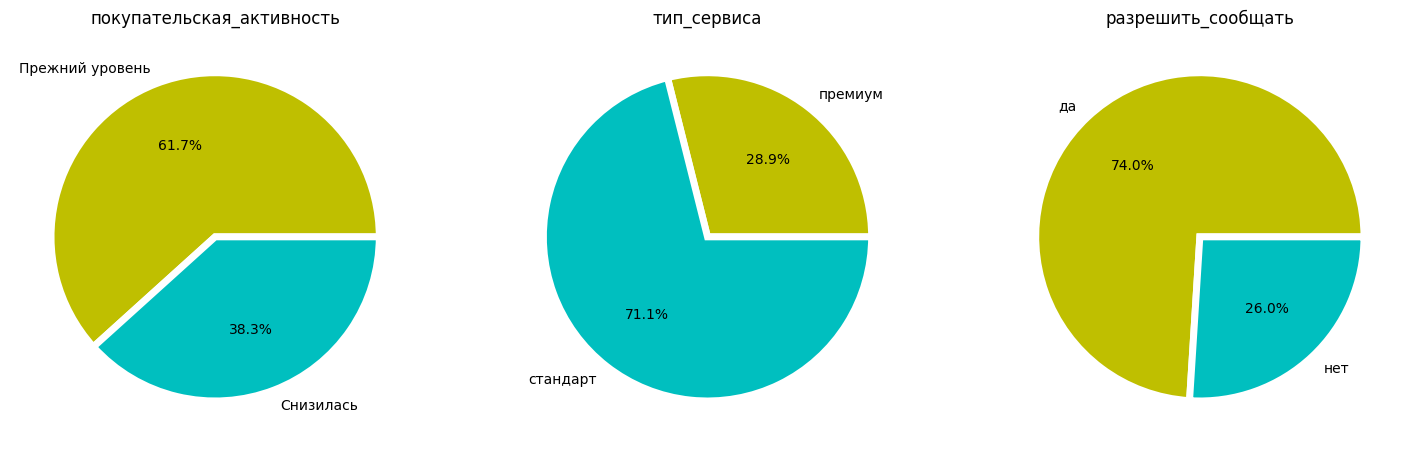

In [21]:
cat_df_market = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать']
i=1
plt.figure(figsize=(18,10))
for column in cat_df_market:
    plt.subplot(1, 3, i)
    plt.title(column)
    plt.pie(x=df_market.groupby(column)['id'].count(),
        wedgeprops={'linewidth':5, 'edgecolor':'white'},
        autopct='%1.1f%%',
        labels=df_market.groupby(column)['id'].count().index,
        colors=['y', 'c']);
    i+=1

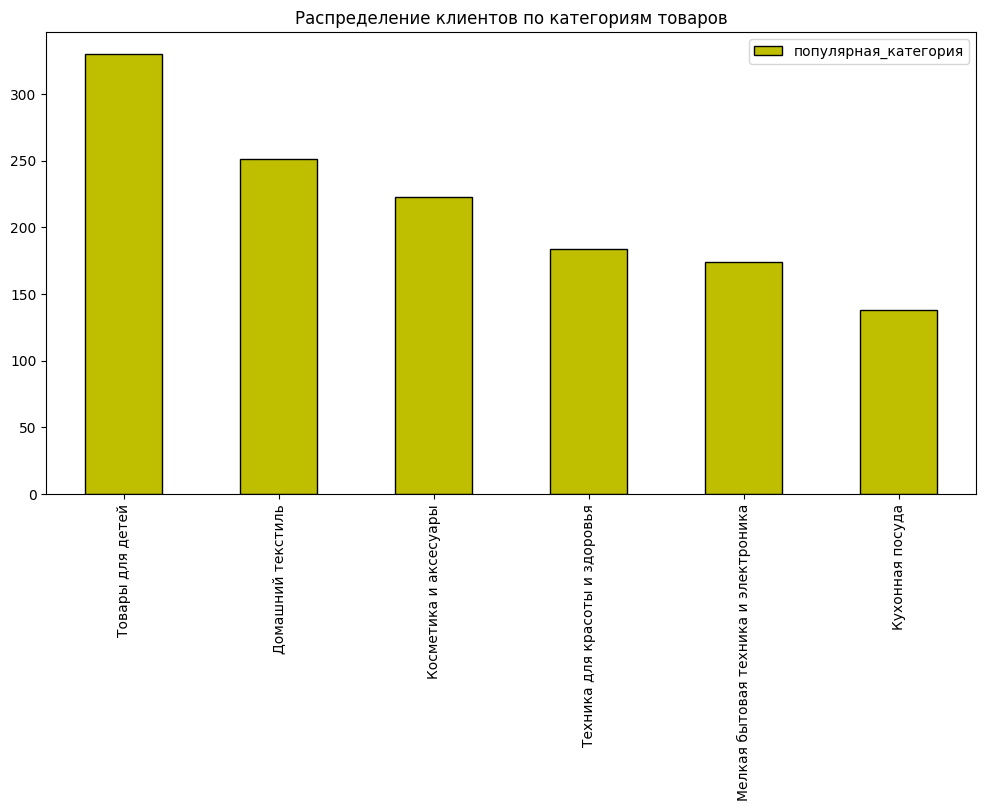

In [22]:
plt.figure(figsize=(12,6))
df_market['популярная_категория'].value_counts().plot(kind='bar', label='популярная_категория', color='y', ec='black')
plt.legend()
plt.title('Распределение клиентов по категориям товаров');

**Почти у 40% клиентов падает активность месяц к месяцу. Возможно у большинства из них запрещена рассылка сообщений. Также это может быть связано с покупкой долгосрочных товаров. Нет необходимости покупать электронику каждый месяц.**

**Для `df_market_money`:**

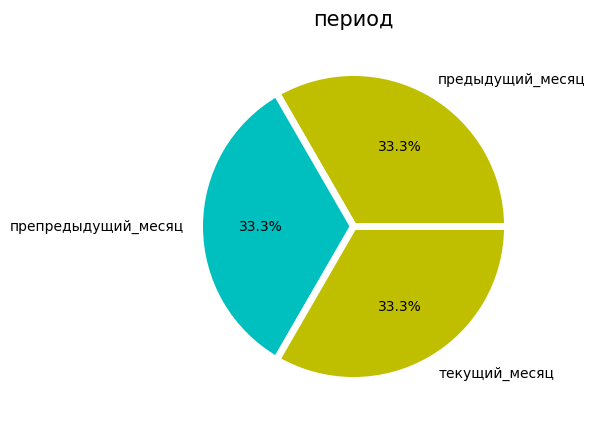

In [23]:
plt.figure(figsize=(5,5))
plt.title('период', size=15)
plt.pie(x=df_market_money.groupby('период')['id'].count(),
        wedgeprops={'linewidth':5, 'edgecolor':'white'},
        autopct='%1.1f%%',
        labels=df_market_money.groupby('период')['id'].count().index,
        colors=['y', 'c']);

**Данные распределены равномерно по месяцам.**

**Для `df_market_time`:**

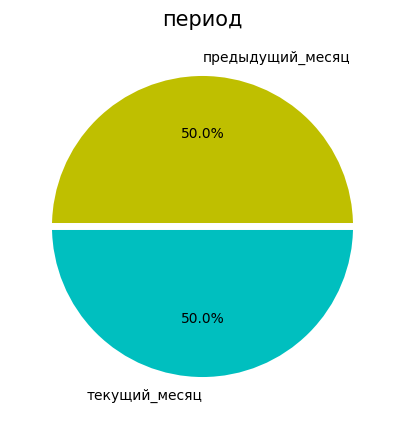

In [24]:
plt.figure(figsize=(5,5))
plt.title('период', size=15)
plt.pie(x=df_market_time.groupby('период')['id'].count(),
        wedgeprops={'linewidth':5, 'edgecolor':'white'},
        autopct='%1.1f%%',
        labels=df_market_time.groupby('период')['id'].count().index,
        colors=['y', 'c']);

**В датасете только 2 месяца, поэтому данные разделены поровну.**

**Перейдем к категориальным признакам. Создадим универсальную функцию вывода графиков:**

In [25]:
def num_graph(data, column):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title(f'Распределение клиентов по {column}')
    plt.hist(x=data[column], histtype ='bar', bins=30, ec='black', color='c')
    plt.subplot(1, 2, 2)
    plt.xlabel(column)
    plt.title(f'Распределение клиентов по {column}')
    plt.boxplot(x=data[column])

**Для `df_market`:**

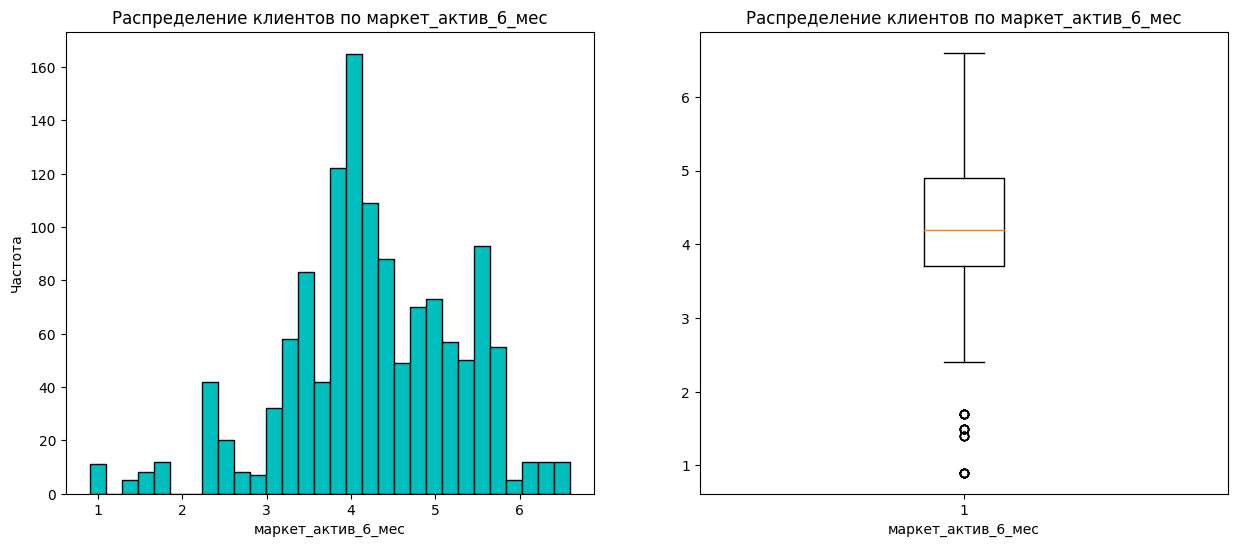

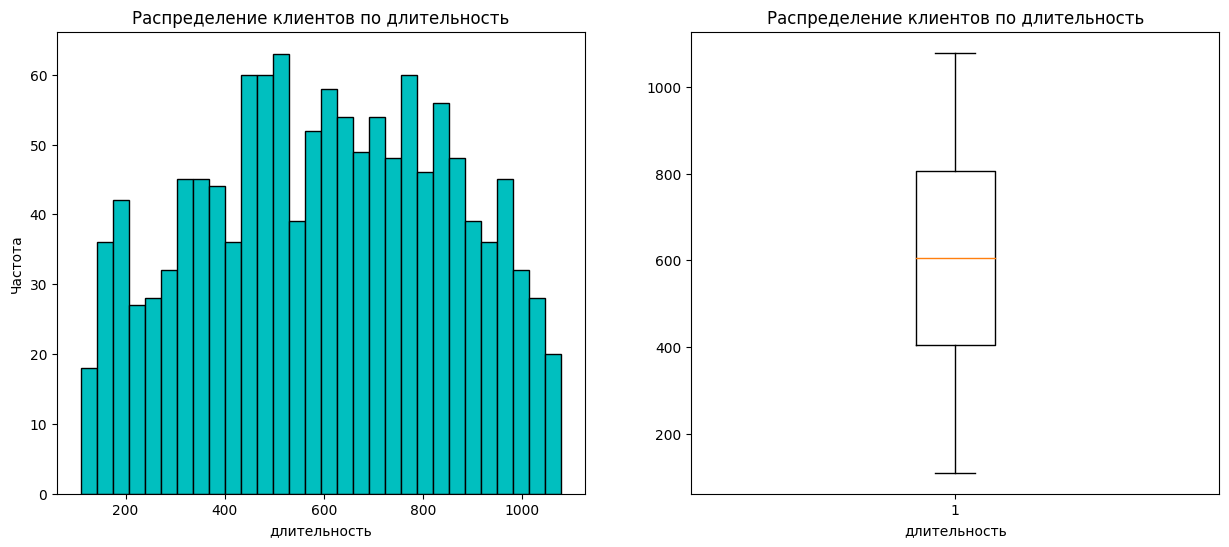

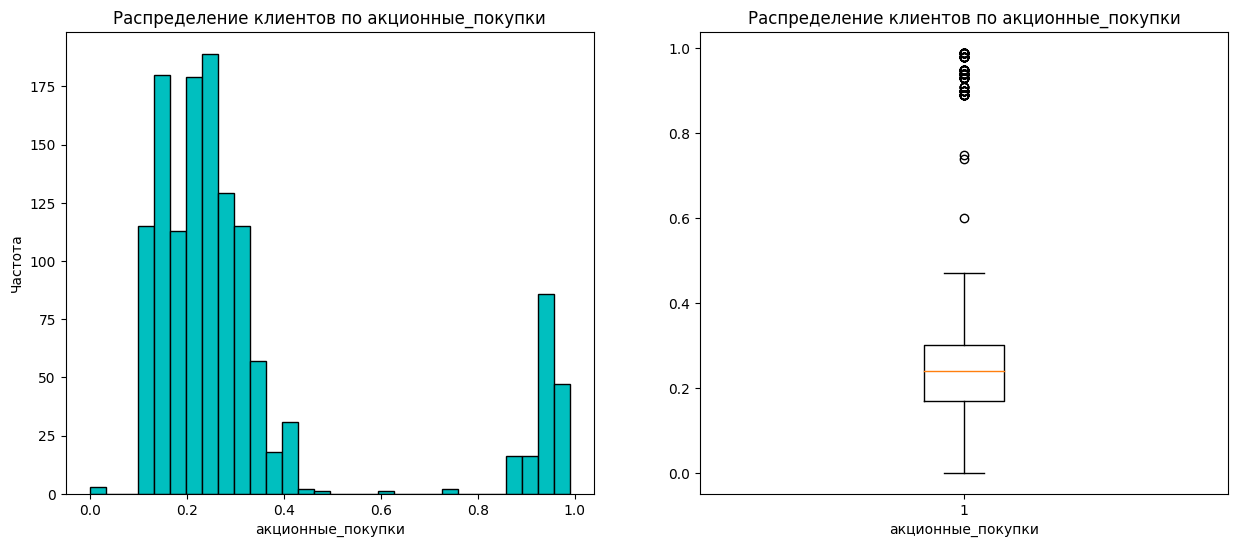

In [26]:
num_df_market = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки']

for num in num_df_market:
    num_graph(df_market, num)

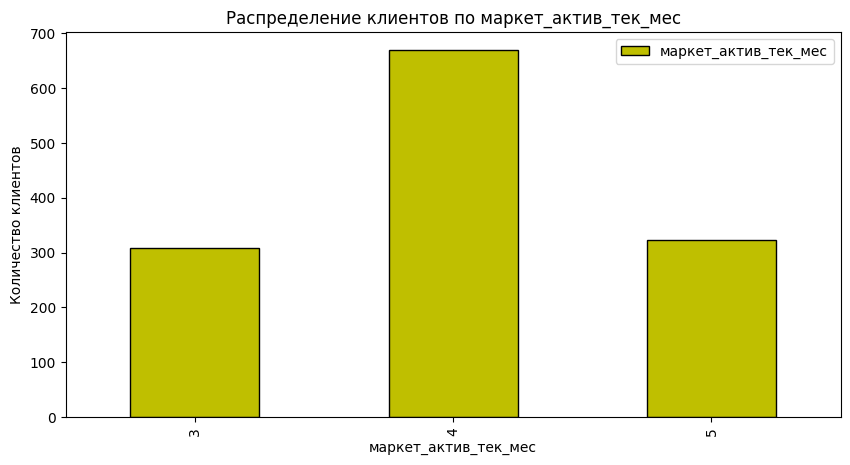

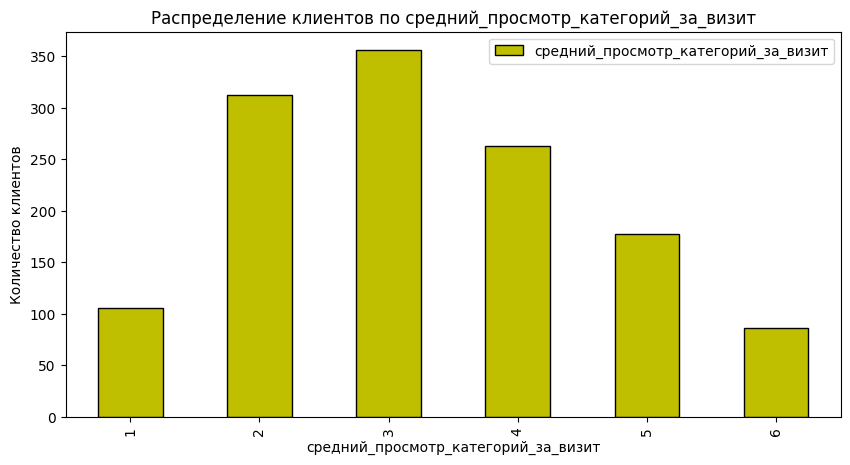

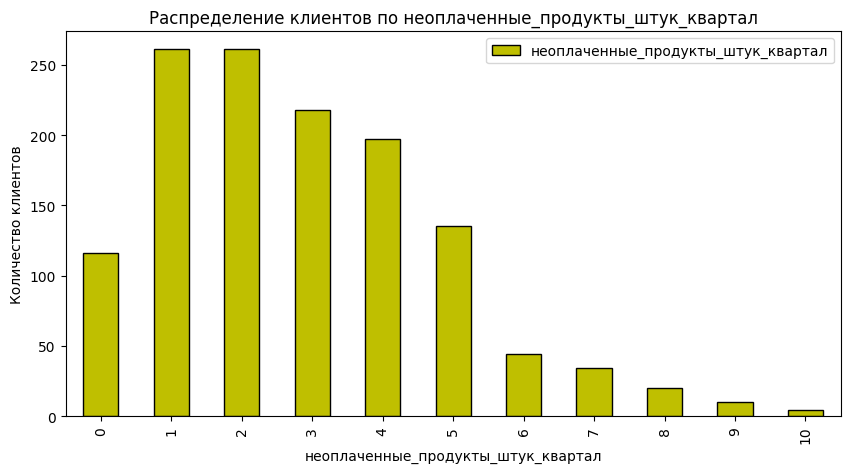

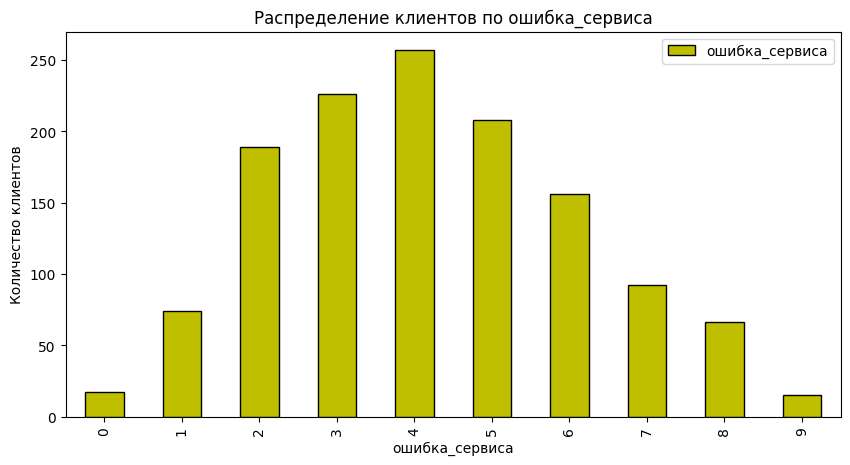

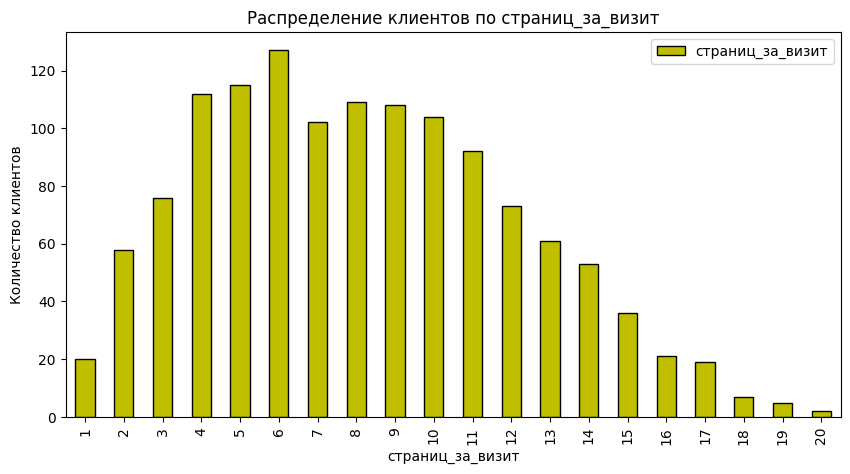

In [27]:
cat_df_market = ['маркет_актив_тек_мес', 'cредний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
                 'ошибка_сервиса', 'страниц_за_визит']

for cat in cat_df_market:
    plt.figure(figsize=(10,5))
    df_market[cat].value_counts(sort=False).plot(kind='bar', color='y', ec='black')
    plt.legend()
    plt.title(f'Распределение клиентов по {cat}');
    plt.ylabel('Количество клиентов')
    plt.xlabel(f'{cat}')
    



* Гистограмма маркетинговой активности за 6 месяцев имеет вид нормальной. Из общего числа выбивается несколько низких значений.
* Уникальных значений в активности за текущий месяц слишком мало, можно сделать признак категориальным.
* Признак длительности с момента регистрации распределен равномерно, имеются острые пики в некоторые даты.
* У признака покупок по акции наблюдается два пика. Есть покупатели, взявшие товар только по скидке.
* Гистограмма признака просмотра категорий за визит имеет вид нормальной. В среднем клиенты просматривают три категории товаров за визит.
* Гистограмма признака колличество неоплаченных товаров в корзине имеет смещение пика влево. Имеется несколько случаев с количеством товаров более 8 штук.
* Признак количества сбоев имеет вид нормального распределения.
* Гистограмма признака колличество страниц на сайте за визит имеет смещение пика влево. В среднем клиенты просматривают около 7 страниц за визит.

**Для `df_market_money`:**

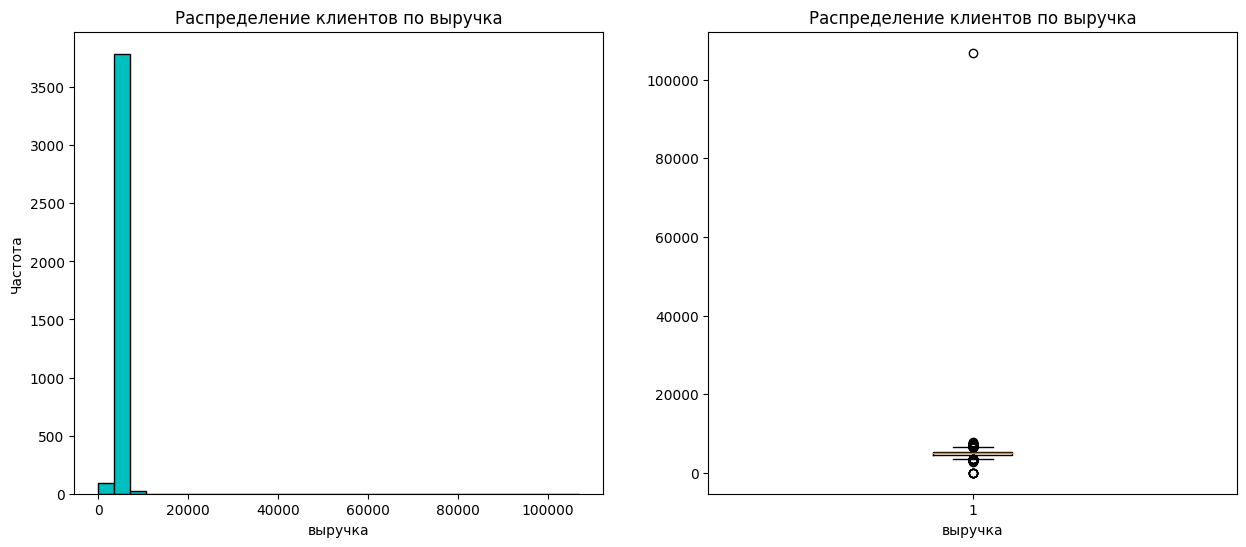

In [28]:
num_df_market_money = ['выручка']

for num in num_df_market_money:
    num_graph(df_market_money, num)

**Виднеется аномально большое значение выручки за месяц. Возможно, данный покупатель взял товары из раздела электроники оптом. Т.к. данный случай только один, его лучше уберем:**

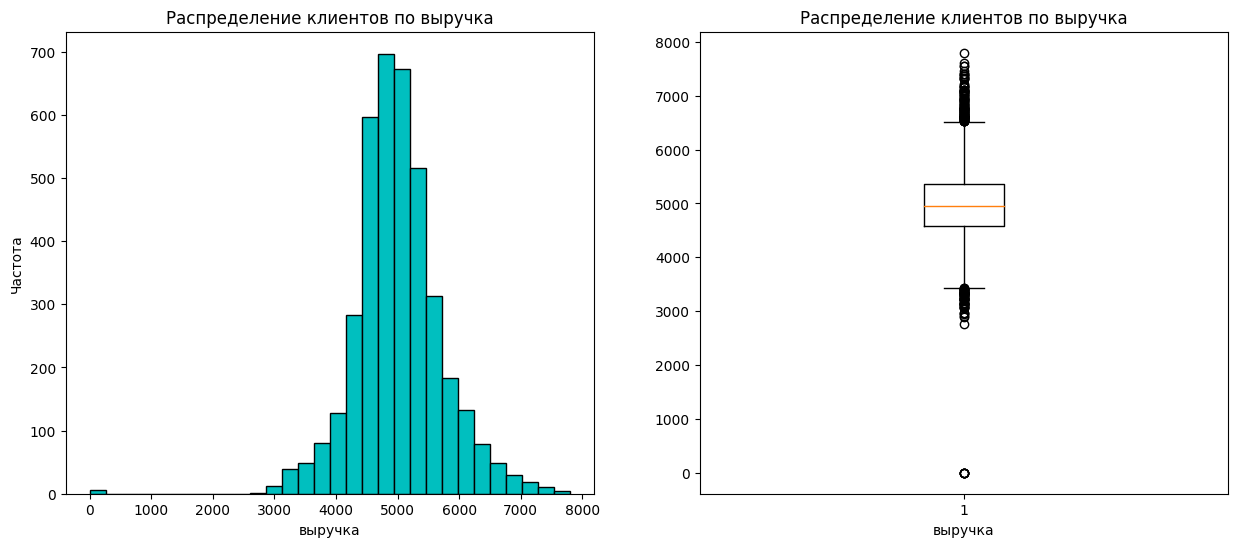

In [29]:
df_market_money = df_market_money.query('выручка < 20000')

for num in num_df_market_money:
    num_graph(df_market_money, num)

**Теперь видим клиентов, не совершавших покупок за данный период, позже удалим из датасета.**

* Гистограмма распределяется нормально. В среднем с покупателя сервис получает 5000 р. выручки.

**Для `df_market_time`:**

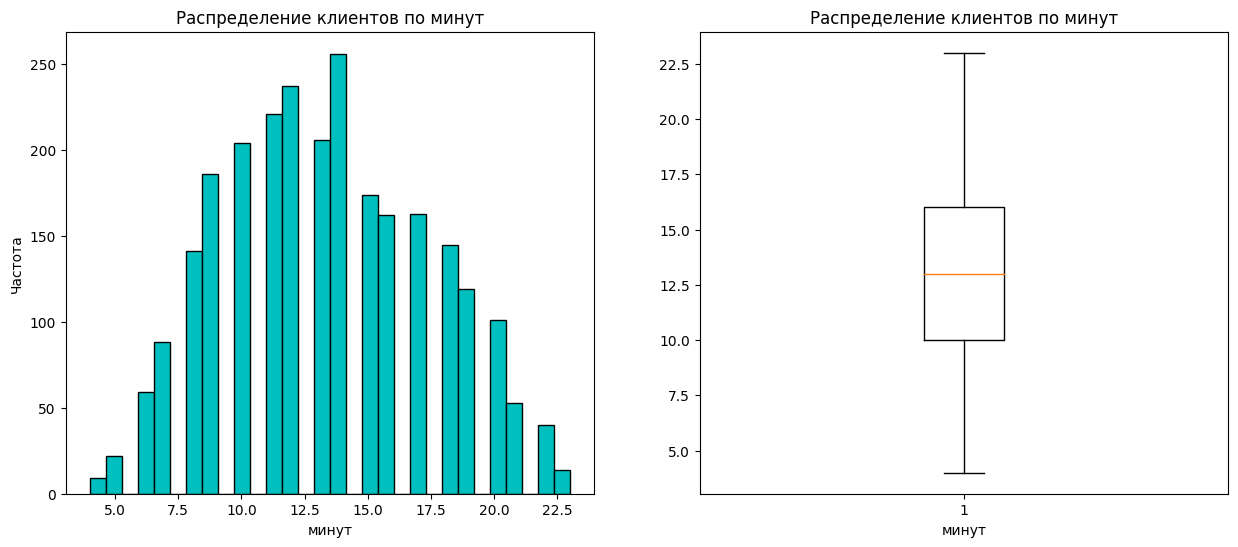

In [30]:
num_df_market_time = ['минут']

for num in num_df_market_time:
    num_graph(df_market_time, num)

* Гистограмма времени, проведенного на сайте имеет вид нормальной.

**Для `df_money`:**

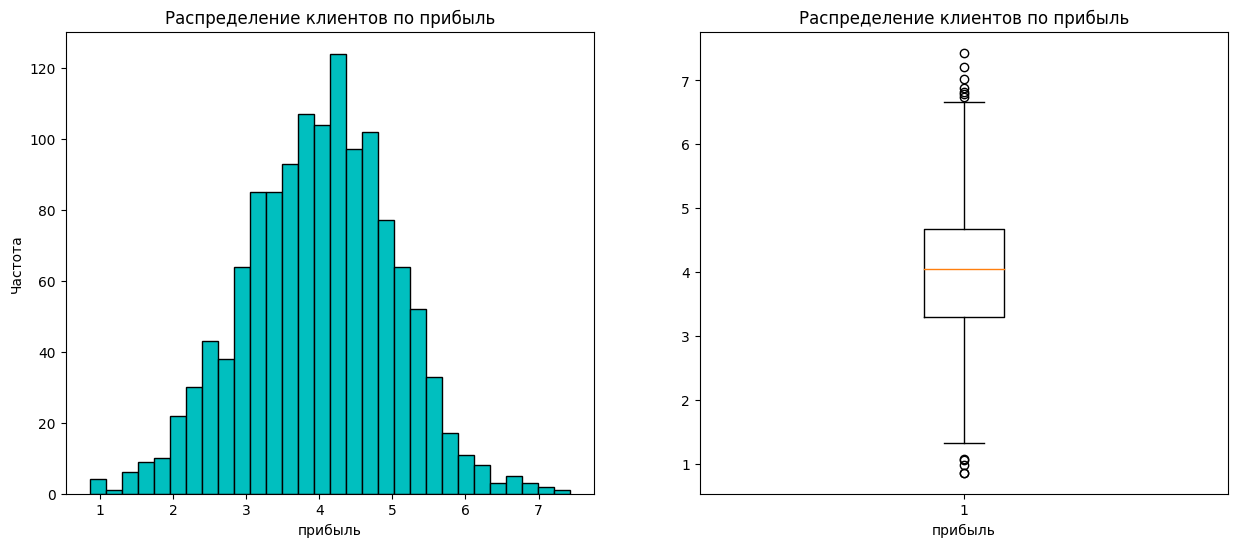

In [31]:
num_df_money = ['прибыль']

for num in num_df_money:
    num_graph(df_money, num)

* Гистограмма прибыли распределена нормально.

**Посмотрим на клиентов с покупательской активностью менее 3 месяцев:**

In [32]:
df_market_money.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


**Уберем данных пользователей из датасетов:**

In [33]:
print('df_market' ,df_market.shape)
print('df_market_money', df_market_money.shape)
print('df_market_time', df_market_time.shape)
print('df_money', df_money.shape)

df_market (1300, 13)
df_market_money (3899, 3)
df_market_time (2600, 3)
df_money (1300, 2)


In [34]:
df_market = df_market.query('id != [215348, 215357, 215359]')
df_market_money = df_market_money.query('id != [215348, 215357, 215359]')
df_market_time = df_market_time.query('id != [215348, 215357, 215359]')
df_money = df_money.query('id != [215348, 215357, 215359]')

print('df_market' ,df_market.shape)
print('df_market_money', df_market_money.shape)
print('df_market_time', df_market_time.shape)
print('df_money', df_money.shape)

df_market (1297, 13)
df_market_money (3890, 3)
df_market_time (2594, 3)
df_money (1297, 2)


**Промежуточный вывод:**
* Для каждого датасета построили гистограммы количественных признаков, диаграммы категориальных прихнаков и описали графики.
* Избавились от пользователей с активностью менее 3 месяцев и 1 аномального случая. 

## Объединение таблиц

**Объединим таблицы `df_market` и `df_market_money`. Для этого определим несколько датасетов по периоду:**

In [35]:
df_now_mes = (df_market_money.query('период == "текущий_месяц"').drop(['период'], axis=1)
              .rename(columns={'выручка': 'выручка_текущий_мес'}))
df_pre_mes = (df_market_money.query('период == "предыдущий_месяц"').drop(['период'], axis=1)
              .rename(columns={'выручка': 'выручка_предыдущий_мес'}))
df_prepre_mes = (df_market_money.query('период == "препредыдущий_месяц"').drop(['период'], axis=1)
                 .rename(columns={'выручка': 'выручка_препредыдущий_мес'}))

In [36]:
df = (df_market.merge(df_now_mes, on='id')
      .merge(df_pre_mes, on='id')
      .merge(df_prepre_mes, on='id')
      .reset_index(drop=True))

print(df.shape)
df.sample(20, random_state=1)

(1296, 16)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,cредний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_мес,выручка_предыдущий_мес,выручка_препредыдущий_мес
971,216323,Прежний уровень,стандарт,да,4.1,4,927,0.24,Домашний текстиль,2,5,4,11,6722.0,5584.5,4422.0
649,216001,Прежний уровень,премиум,да,5.3,3,973,0.17,Домашний текстиль,4,2,4,11,6835.4,5700.5,4541.0
60,215412,Снизилась,премиум,да,2.9,3,506,0.90,Товары для детей,1,5,3,4,5294.1,5499.5,4607.0
941,216293,Прежний уровень,премиум,да,4.4,4,866,0.17,Мелкая бытовая техника и электроника,3,1,6,12,5109.0,4985.5,4993.0
944,216296,Прежний уровень,стандарт,да,5.1,3,994,0.13,Товары для детей,4,3,1,7,4859.5,4645.0,4742.0
593,215945,Прежний уровень,премиум,да,4.0,3,1007,0.23,Кухонная посуда,2,3,6,7,4044.8,4420.5,5004.0
133,215485,Снизилась,стандарт,да,3.5,4,720,0.99,Косметика и аксесуары,1,2,4,7,5065.5,4201.0,4234.0
142,215494,Снизилась,стандарт,нет,5.6,5,372,0.23,Косметика и аксесуары,1,6,2,3,5784.5,5258.0,4502.0
453,215805,Снизилась,стандарт,нет,4.1,4,808,0.15,Мелкая бытовая техника и электроника,4,2,3,13,4746.1,4126.0,4691.0
409,215761,Прежний уровень,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,3713.8,4252.0,5023.0


**Проделаем то же самое с датасетом `df_market_time`:**

In [37]:
df_time_now_mes = (df_market_time.query('период == "текущий_месяц"').drop(['период'], axis=1)
              .rename(columns={'минут': 'минут_текущий_мес'}))
df_time_pre_mes = (df_market_time.query('период == "предыдущий_месяц"').drop(['период'], axis=1)
              .rename(columns={'минут': 'минут_предыдущий_мес'}))

In [38]:
full_df = (df.merge(df_time_now_mes, on='id')
           .merge(df_time_pre_mes, on='id')
           .reset_index(drop=True))

print(full_df.shape)
full_df.sample(10, random_state=1)

(1296, 18)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,cредний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_мес,выручка_предыдущий_мес,выручка_препредыдущий_мес,минут_текущий_мес,минут_предыдущий_мес
971,216323,Прежний уровень,стандарт,да,4.1,4,927,0.24,Домашний текстиль,2,5,4,11,6722.0,5584.5,4422.0,14,14
649,216001,Прежний уровень,премиум,да,5.3,3,973,0.17,Домашний текстиль,4,2,4,11,6835.4,5700.5,4541.0,13,12
60,215412,Снизилась,премиум,да,2.9,3,506,0.90,Товары для детей,1,5,3,4,5294.1,5499.5,4607.0,9,10
941,216293,Прежний уровень,премиум,да,4.4,4,866,0.17,Мелкая бытовая техника и электроника,3,1,6,12,5109.0,4985.5,4993.0,10,19
944,216296,Прежний уровень,стандарт,да,5.1,3,994,0.13,Товары для детей,4,3,1,7,4859.5,4645.0,4742.0,13,10
593,215945,Прежний уровень,премиум,да,4.0,3,1007,0.23,Кухонная посуда,2,3,6,7,4044.8,4420.5,5004.0,23,19
133,215485,Снизилась,стандарт,да,3.5,4,720,0.99,Косметика и аксесуары,1,2,4,7,5065.5,4201.0,4234.0,14,10
142,215494,Снизилась,стандарт,нет,5.6,5,372,0.23,Косметика и аксесуары,1,6,2,3,5784.5,5258.0,4502.0,13,9
453,215805,Снизилась,стандарт,нет,4.1,4,808,0.15,Мелкая бытовая техника и электроника,4,2,3,13,4746.1,4126.0,4691.0,16,12
409,215761,Прежний уровень,стандарт,нет,5.7,4,565,0.14,Домашний текстиль,5,1,4,12,3713.8,4252.0,5023.0,18,12


**Промежуточный вывод:**
* Объединили датасеты в оди `full_df`.
* Столбцы с выручкой и временем сессии разделили на несколько в зависимости от периода.
* Итоговый датасет имеет 1296 записей клиентов с 18 признаками, включая уникальный id.

## Корреляционный анализ

**Выведем корреляционную матрицу признаков. Т.к. не все признаки распределены нормально, будем использовать корреляцию Спирмана.**

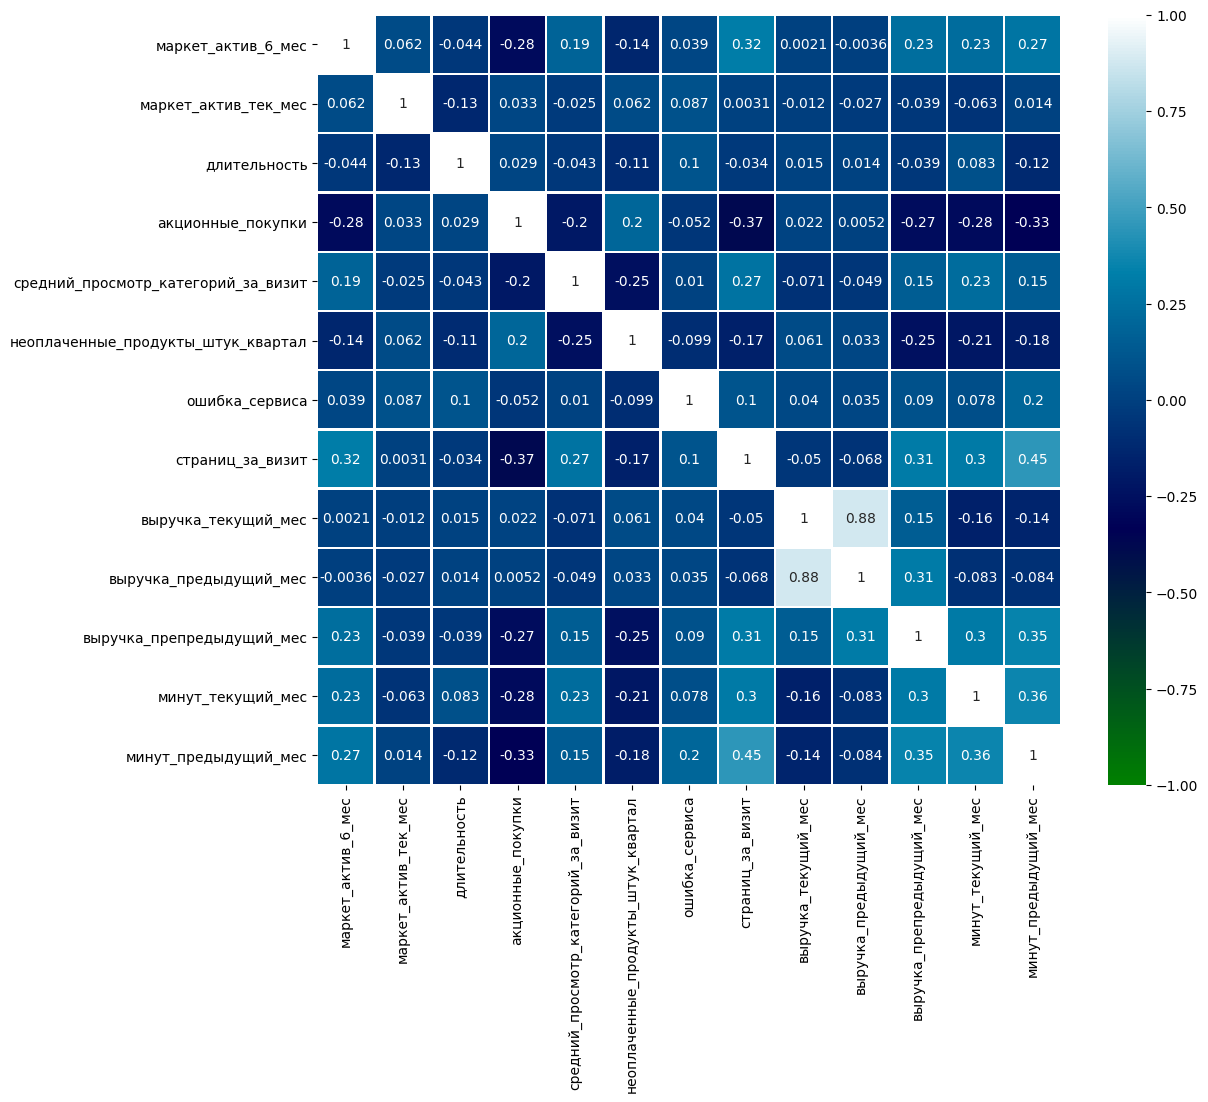

In [39]:
columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
           'cредний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
           'страниц_за_визит', 'выручка_текущий_мес', 'выручка_предыдущий_мес', 'выручка_препредыдущий_мес',
           'минут_текущий_мес', 'минут_предыдущий_мес']
plt.figure(figsize = (12,10))
sns.heatmap(full_df[columns].corr(method="spearman"), 
            annot=True, vmin=-1, fmt='.2g', linecolor='w', linewidths=1, cmap='ocean');

**Наблюдается высокая корреляция между выручками за текущий и предыдущий месяцы. Мультиколиинеарности не обнаружено.**

## Использование пайплайнов

**Разобьем датасет на тренировочную и тестовую выборки, закодируем признаки и создадим пайплайн:**

In [40]:
TEST_SIZE = 0.25
RANDOM_STATE = 42

X = full_df.drop(['покупательская_активность','id'], axis=1)
y = full_df['покупательская_активность'] 

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE,
                                                    stratify = y)

#переведем строковые значения целевого признака в порядковые числа
label_encoder = LabelEncoder()
y_train_1 = label_encoder.fit_transform(y_train)
y_test_1 = label_encoder.transform(y_test)


cat_col = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

num_col = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
           'cредний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
           'страниц_за_визит', 'выручка_текущий_мес', 'выручка_предыдущий_мес', 'выручка_препредыдущий_мес',
           'минут_текущий_мес', 'минут_предыдущий_мес'] 


ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent')), 
        ('ohe', 
         OneHotEncoder(drop='first', 
                       handle_unknown='error', 
                       sparse=False))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent')),
        ('ord', 
         OrdinalEncoder(categories=[
             ['стандарт', 'премиум'], 
             ['да', 'нет'],
             ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', 'Техника для красоты и здоровья',
              'Кухонная посуда', 'Мелкая бытовая техника и электроника']], 
    handle_unknown='use_encoded_value', 
    unknown_value=np.nan))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('ord', ord_pipe, cat_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)


pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

#Параметры для передачи GridSearchCV для поиска оптимальной модели 
#с разными Scaler и Encoder

param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 25),
        'models__max_features': range(2, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 


**Построим перебор методов маштабирования и самих моделей с помощью метода `GridSearchCV`. Т.к. в датасете объектов с одним значением целевого признака больше, чем с другим, будем использовать метрику ROC-AUC:**

In [41]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1)

grid.fit(X_train, y_train_1)

print('Метрика ROC-AUC лучшей модели:\n', grid.best_score_) 
print('Лучшая модель и её параметры:\n\n', grid.best_params_)

Метрика ROC-AUC лучшей модели:
 0.8646134465043556
Лучшая модель и её параметры:

 {'models': KNeighborsClassifier(n_neighbors=3), 'models__n_neighbors': 3, 'preprocessor__num': StandardScaler()}


C:\Users\Diadaro\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.86461345 0.84425143 0.74929177 ... 0.89646162 0.8974034  0.87949658]
  warnings.warn(
C:\Users\Diadaro\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:931: RuntimeWarning: invalid value encountered in cast
  results["rank_%s" % key_name] = np.asarray(


**Даже после перебора гиперпараметров лучшая модель и значение метрики модели не изменились. Применим модель к тестовым данным:**

In [42]:
y_pred = grid.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_1, y_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.910933139182138


**На тестовой выборке модель показала себя еще лучше. Отличный результат.**

## Анализ важности признаков

**Займемся оценкой важности признаков модели:**

In [47]:
ohe_encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

X_train_ohe = ohe_encoder.fit_transform(X_train[cat_col])
X_test_ohe = ohe_encoder.transform(X_test[cat_col])
ohe_encoder_col_names = ohe_encoder.get_feature_names()


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col])
X_test_scaled = scaler.transform(X_test[num_col])


X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)


X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)


X_train_final = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_final = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model = SVC(kernel='linear', probability=True, random_state=42)
model.fit(X_train_final, y_train_1)

SVC(kernel='linear', probability=True, random_state=42)

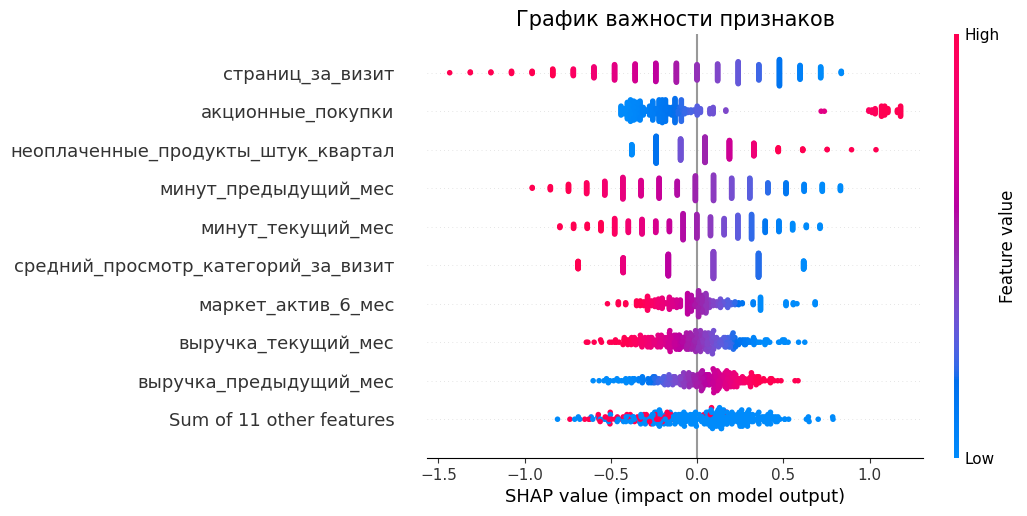

In [50]:
explainer = shap.LinearExplainer(model, X_test_final)
shap_values = explainer(X_test_final)

plt.title('График важности признаков', size=15)
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0))
plt.show();

* Значения страниц_за_визит и минут_предыдущий_месяц увеличивают вероятность принадлежности наблюдений к классу 0.
* Значения акционные_покупки и неоплаченные продукты в корзине увеличивают значения SHAP-объектов и увеличивают вероятность принадлежности наблюдений к классу 1.

**Промежуточный вывод:**
Логично, что количество посещенных страниц, минуты на сайте по месяцам и средний просмотр категорий за визит влияют на целевой покупательская активность больше остальных признаков. Ведь, чем больше страниц клиент посетил, и чем больше минут провел на сайте, тем выше будет его общая активность. Акции также сильно влияют на активность, бизнесу стоит пороработать данный фактор.

## Cегментация покупателей

**Объединим тренировочную и тестовую выборки, добавим столбец с прогнозами и столбец с прибылью:**

In [51]:
model_train = model.predict_proba(X_train_final)[:,1]
model_test = model.predict_proba(X_test_final)[:,1]

full_train = pd.concat([X_train, y_train], axis=1)
full_test = pd.concat([X_test, y_test], axis=1)

X_train_pred = model.predict(X_train_final)
full_train['прогноз'] = X_train_pred.tolist()
full_train['вероятность_прогноза'] = model_train.tolist()

X_test_pred = model.predict(X_test_final)
full_test['прогноз'] = X_test_pred.tolist()
full_test['вероятность_прогноза'] = model_test.tolist()

pred_df = pd.concat([full_train, full_test])
pred_df = pd.merge(pred_df, full_df['id'], left_index=True, right_index=True)

pred_df = pred_df.merge(df_money, on='id')
    
print(pred_df.shape)
pred_df.head(10)

(1296, 21)


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,cредний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_мес,выручка_предыдущий_мес,выручка_препредыдущий_мес,минут_текущий_мес,минут_предыдущий_мес,покупательская_активность,прогноз,вероятность_прогноза,id,прибыль
0,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,6014.2,5170.5,4347.0,6,20,Прежний уровень,0,0.058143,215858,4.37
1,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,3789.7,6400.0,4597.0,13,11,Снизилась,1,0.810012,215361,4.03
2,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,3798.4,4113.0,4626.0,10,13,Прежний уровень,0,0.116640,215884,4.37
3,стандарт,да,5.6,4,342,0.94,Кухонная посуда,2,7,5,8,4766.2,4930.0,5269.0,19,14,Прежний уровень,1,0.743591,216564,5.58
4,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,2,5,4600.0,3716.0,4691.0,10,10,Снизилась,1,0.778945,215715,4.87
5,стандарт,нет,5.7,5,769,0.14,Техника для красоты и здоровья,4,1,8,10,5180.3,5868.0,4925.0,20,15,Прежний уровень,0,0.019050,216533,6.59
6,стандарт,да,3.0,4,304,0.25,Домашний текстиль,1,6,5,3,4762.2,4789.5,4305.0,11,11,Снизилась,1,0.963230,215674,2.72
7,премиум,да,6.1,3,1056,0.17,Домашний текстиль,2,3,7,8,4423.0,4767.5,5315.0,17,15,Прежний уровень,0,0.190786,216334,4.84
8,стандарт,да,4.3,4,831,0.21,Мелкая бытовая техника и электроника,5,2,3,7,3287.0,3872.0,4697.0,17,11,Прежний уровень,0,0.186875,216186,6.29
9,стандарт,да,5.6,4,157,0.30,Товары для детей,6,3,2,9,4765.0,4505.0,4655.0,14,13,Прежний уровень,0,0.112735,216526,5.11


In [52]:
pred_df['прогноз'] = pred_df['прогноз'].apply(lambda x: 'не изменится' if x==0 else 'снизится')

print(pred_df.shape)
pred_df.head(10)

(1296, 21)


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,cредний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_мес,выручка_предыдущий_мес,выручка_препредыдущий_мес,минут_текущий_мес,минут_предыдущий_мес,покупательская_активность,прогноз,вероятность_прогноза,id,прибыль
0,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,6014.2,5170.5,4347.0,6,20,Прежний уровень,не изменится,0.058143,215858,4.37
1,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,3789.7,6400.0,4597.0,13,11,Снизилась,снизится,0.810012,215361,4.03
2,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,3798.4,4113.0,4626.0,10,13,Прежний уровень,не изменится,0.116640,215884,4.37
3,стандарт,да,5.6,4,342,0.94,Кухонная посуда,2,7,5,8,4766.2,4930.0,5269.0,19,14,Прежний уровень,снизится,0.743591,216564,5.58
4,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,2,5,4600.0,3716.0,4691.0,10,10,Снизилась,снизится,0.778945,215715,4.87
5,стандарт,нет,5.7,5,769,0.14,Техника для красоты и здоровья,4,1,8,10,5180.3,5868.0,4925.0,20,15,Прежний уровень,не изменится,0.019050,216533,6.59
6,стандарт,да,3.0,4,304,0.25,Домашний текстиль,1,6,5,3,4762.2,4789.5,4305.0,11,11,Снизилась,снизится,0.963230,215674,2.72
7,премиум,да,6.1,3,1056,0.17,Домашний текстиль,2,3,7,8,4423.0,4767.5,5315.0,17,15,Прежний уровень,не изменится,0.190786,216334,4.84
8,стандарт,да,4.3,4,831,0.21,Мелкая бытовая техника и электроника,5,2,3,7,3287.0,3872.0,4697.0,17,11,Прежний уровень,не изменится,0.186875,216186,6.29
9,стандарт,да,5.6,4,157,0.30,Товары для детей,6,3,2,9,4765.0,4505.0,4655.0,14,13,Прежний уровень,не изменится,0.112735,216526,5.11


**Рассмотрим, долю покупателей, популярная категория которых - домашний текстиль. Разобъем полученный датасет на две части по вероятности снижения активности:**

In [53]:
home_textiles = pred_df.query('популярная_категория == "Домашний текстиль"')
home_textiles.sample(10)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,cредний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_текущий_мес,выручка_предыдущий_мес,выручка_препредыдущий_мес,минут_текущий_мес,минут_предыдущий_мес,покупательская_активность,прогноз,вероятность_прогноза,id,прибыль
209,стандарт,нет,6.6,3,274,0.15,Домашний текстиль,5,0,4,9,5550.8,5107.5,4746.0,14,22,Прежний уровень,не изменится,0.014106,216255,3.20
224,премиум,да,4.4,4,993,0.17,Домашний текстиль,2,3,9,8,5927.2,5343.5,4820.0,12,12,Прежний уровень,не изменится,0.464726,216424,2.19
162,премиум,да,5.4,3,491,0.15,Домашний текстиль,2,5,4,11,4514.6,4973.5,5653.0,16,21,Прежний уровень,не изменится,0.092703,216347,3.68
422,стандарт,да,0.9,4,728,0.90,Домашний текстиль,2,3,2,4,5184.6,4798.5,4377.0,14,10,Снизилась,снизится,0.988535,215617,3.06
1036,стандарт,да,5.2,5,373,0.14,Домашний текстиль,1,4,3,8,4576.8,4751.0,5102.0,14,13,Снизилась,не изменится,0.494804,215906,3.36
1117,стандарт,да,5.4,5,806,0.17,Домашний текстиль,6,1,8,11,6102.4,5565.5,5096.0,19,22,Прежний уровень,не изменится,0.004028,216624,3.72
1263,стандарт,да,0.9,4,212,0.95,Домашний текстиль,2,5,4,2,5161.3,4685.5,4444.0,7,9,Снизилась,снизится,0.997115,215701,5.05
769,стандарт,да,2.4,4,298,0.89,Домашний текстиль,6,3,2,3,4371.2,4665.0,4917.0,5,8,Снизилась,снизится,0.975655,215442,3.04
956,стандарт,да,4.5,4,662,0.16,Домашний текстиль,4,2,3,13,4971.0,4906.0,4981.0,11,18,Прежний уровень,не изменится,0.083055,216022,5.13
1023,премиум,да,4.6,4,800,0.93,Домашний текстиль,4,2,5,4,5549.7,5551.0,4912.0,7,7,Снизилась,снизится,0.966394,215587,3.68


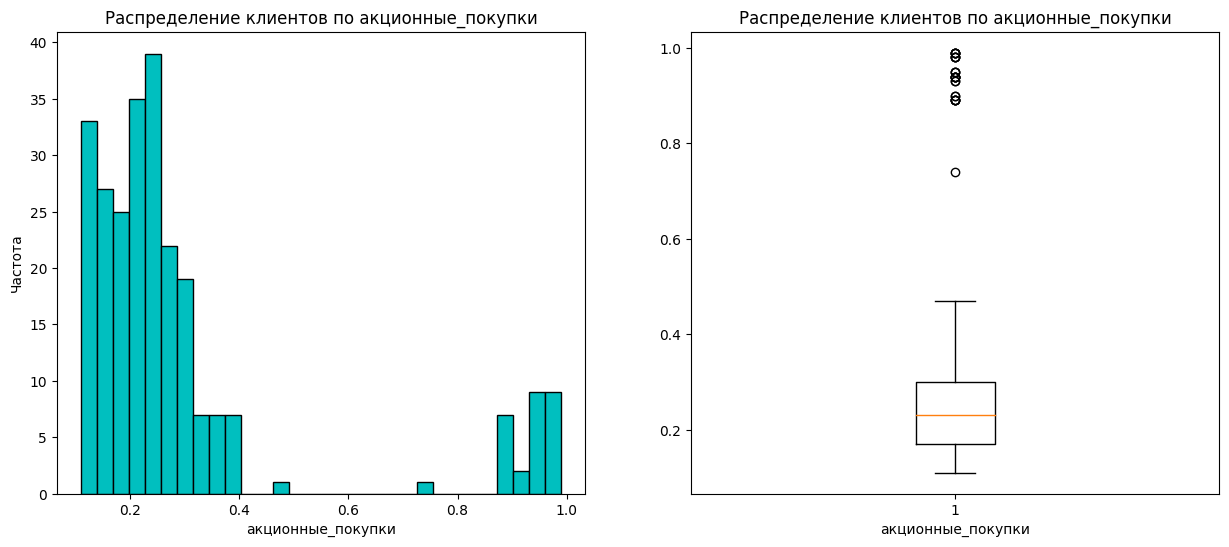

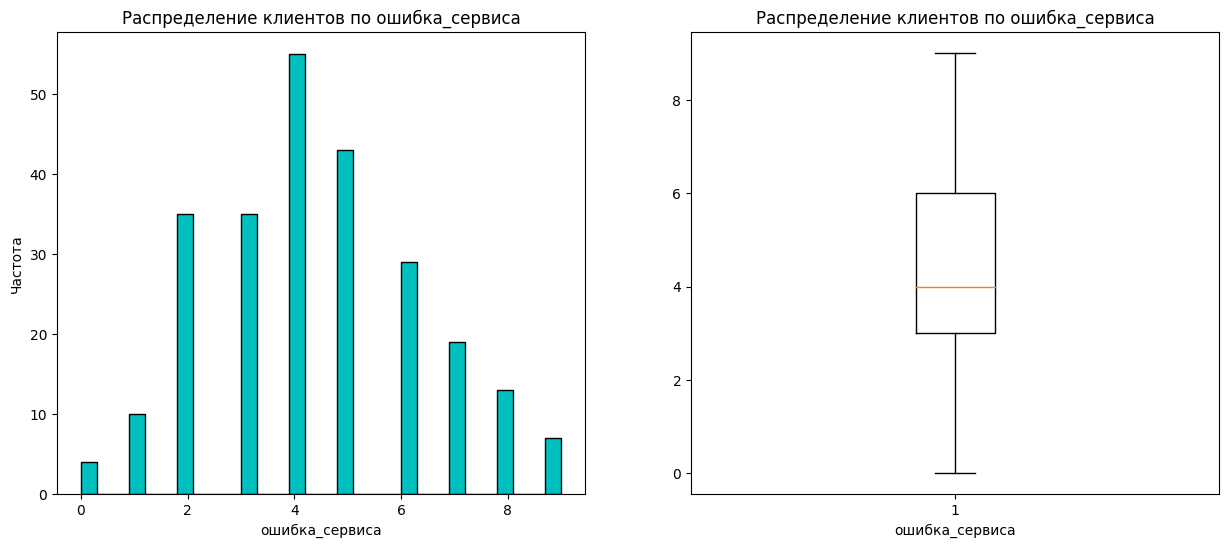

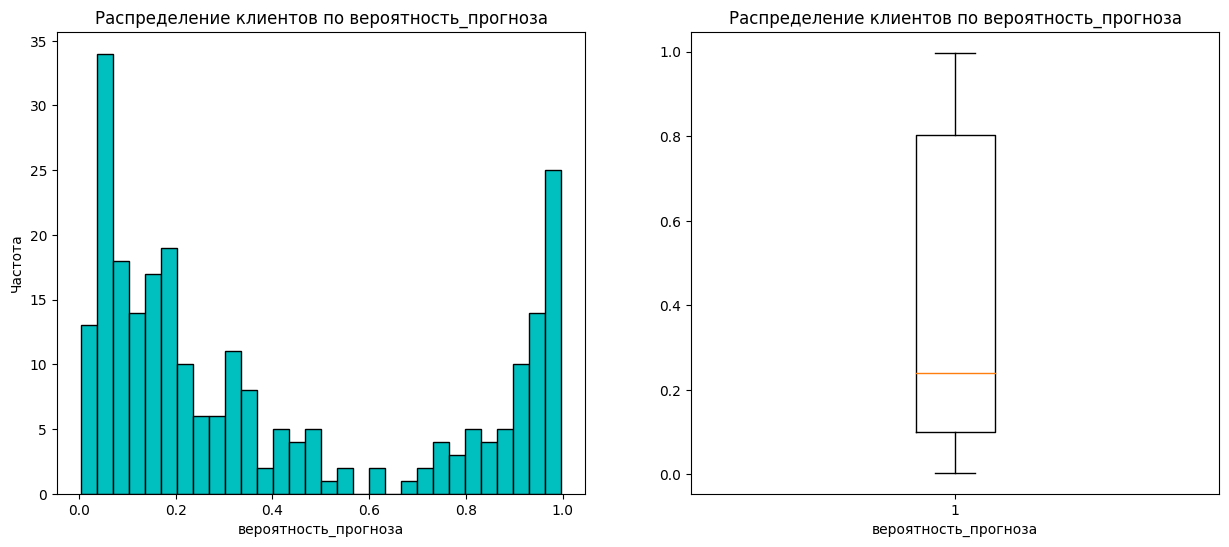

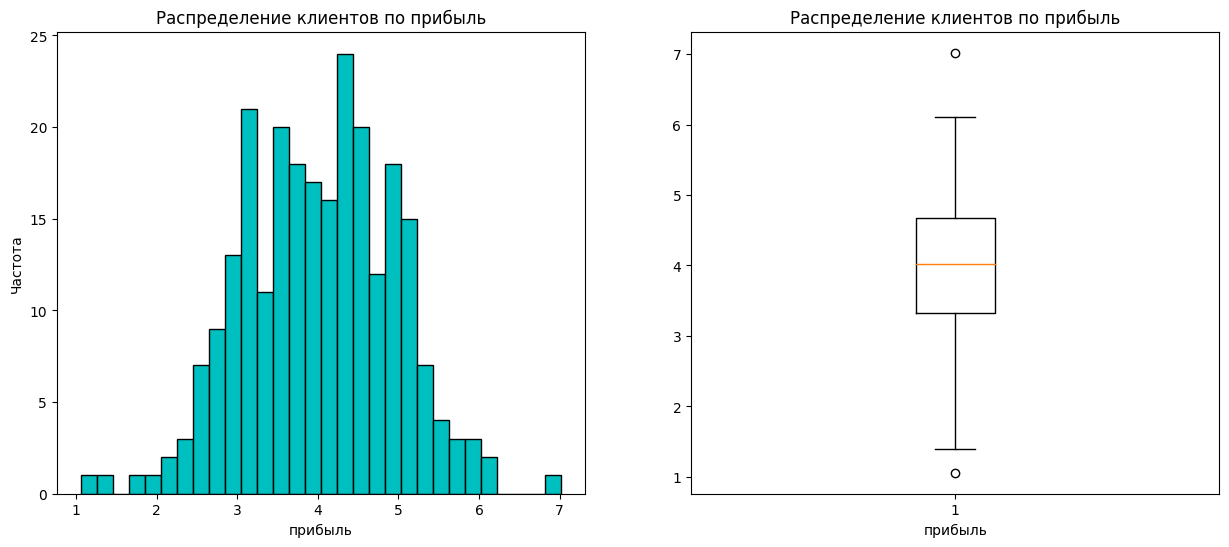

In [54]:
num_home_textiles = ['акционные_покупки', 'ошибка_сервиса', 'вероятность_прогноза', 'прибыль']

for num in num_home_textiles:
    num_graph(home_textiles, num)

In [55]:
count= round((home_textiles.query('вероятность_прогноза>=0.7').shape[0]/home_textiles.shape[0])*100, 2)

print('Количество покупателей категории домашний текстиль:', home_textiles.shape[0])
print(f'Процент покупателей с высокой вероятностью снижения активности:{count}%')

Количество покупателей категории домашний текстиль: 250
Процент покупателей с высокой вероятностью снижения активности:28.8%


**Чуть менее 30% покупателей в данной категории подвержены снижению покупательской активности. Посмотрим, какую прибыль они принесли сервису:**

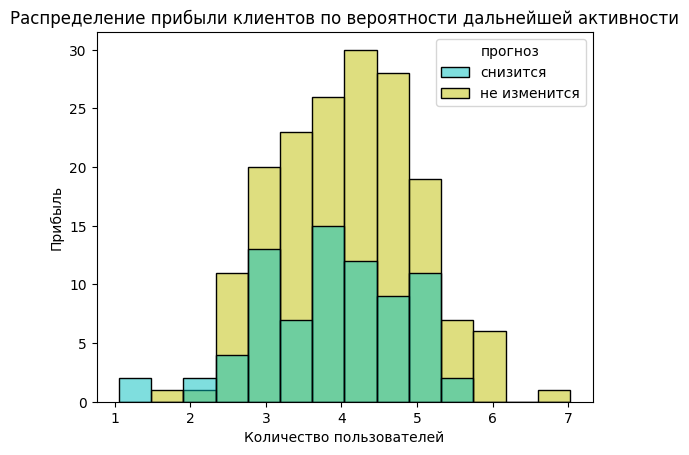

In [56]:
ax = sns.histplot(x = 'прибыль',
           hue = 'прогноз',
           data = home_textiles,
           palette = ['c', 'y'])
ax.set_title('Распределение прибыли клиентов по вероятности дальнейшей активности')
ax.set(xlabel='Количество пользователей', ylabel='Прибыль');

**Из гистограммы получаем, что покупатели с высокой вероятностью снижения активности по прибыльности сопоставимы с активными покупателями. Эту группу клиентов стоит удержать. Выведем статистику по рассылке рекламы:**

In [57]:
print(home_textiles[home_textiles['прогноз'] == 'снизится']['разрешить_сообщать'].value_counts())

да     52
нет    25
Name: разрешить_сообщать, dtype: int64


**Почти у 70% клиентов есть доступ к рекламе. Возможно, стоит ввести персональные предложения на товары. Посмотрим распределление клиентов с вероятностью снижения активности по типам сервиса:**

In [58]:
print('Тип сервиса:\n', home_textiles[home_textiles['прогноз'] == 'снизится']['тип_сервиса'].value_counts())

Тип сервиса:
 стандарт    55
премиум     22
Name: тип_сервиса, dtype: int64


**Выведем количество клиентов с типом сервиса "стандарт" и возможностью рассылок:**

In [59]:
print(home_textiles[(home_textiles['прогноз'] == 'снизится')&
                    (home_textiles['разрешить_сообщать'] == 'да')&
                    (home_textiles['тип_сервиса'] == 'стандарт')]['id'].count())

38


**Стоит присмотреться к данной группе и поискать возможности предоставления премиум сервиса по упрощенной схеме.**

**Промежуточный вывод:**

* Исходный датасет был объединен с предсказаниями модели по всем клиентам.
* Проведен анализ группы клиентов с популярной категорией "домашний текстиль" и вероятностью снижения активности.

**Выводы по анализу сегмента:**

Доля клиентов с высокой вероятностью снижения активности относительно общего числа клиентов категории "домашний текстиль" составляет около 30%. Прибыль данной группы сопоставима с прибылью клиентов с высокой активностью. Почти 70% клиентов этой группы лояльны к рассылке рекламы и такой же процент клиентов имеет тип сервиса "стандарт".


В целях удержания данного сегмента сервису предлагается скорректировать персональные предложения товаров, а также ввести выгодные предложения для клиентов сервиса стандарт по переходу на премиум. Также стоит поработать над разнообразием предлагаемых товаров на сервисе с целью увеличения количества просмотренных страниц и ввести раздел с персональными рекомендациями по прошлой активности.

## Общий вывод

1. От заказчика было получено 4 датасета с исходными данными:
    - market_file.csv - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
    - market_money.csv - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;
    - markt_time.csv - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода;
    - money.csv - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


2. На этапе предобработки все данные были исследованы на наличие пропусков, дубликатов, правильности типов данных. По окончанию знакомства с данными привели названия колонок к единому стилю и избавились от явных и неявных дубликатов.


3. На этапе исследовательского анализа установили следующее:
    - Почти у 40% клиентов падает активность месяц к месяцу. Это может быть связано с запретом рассылки сообщений, с покупкой долгосрочных товаров.
    - Все гистограммы распределены нормально. Исключение составляет признак `длительности времени с момента регистрации`, который распределен равномерно, имеются острые пики в некоторые даты. 
    - Гистограмма признака `покупок по акции` имеет два пика в районе 0.2 и 0.9, второе значение сообщает, что есть клиенты, купившие товары с 80-100% скидкой. 
    - По гистограмме `просмотра категорий за визит` видим, что в среднем клиенты просматривают три категории товаров за визит.
    - Также клиенты просматривают около 7 страниц за визит и имеют около 2 неоплаченных товаров в корзине покупок.
    - На гистограмме выручки было замечено аномально большое значение выручки за месяц. Возможно, данный покупатель взял товары из раздела электроники оптом. Данный покупатель был удален и данных.
    - Клиенты с активностью менее 3 месяцев также были убраны. Таких пользователей оказалось всего 3.


4. В результате объединения таблиц разделили признаки выручки и минут на сайте по периодам. Итоговый датасет имеет 1296 записей клиентов с 18 признаками, включая уникальный id.


5. В ходе корреляционного анализа построили матрицу спирмана, т.к. признак `длительности времени с момента регистрации`, не распределен нормально. На ее основе пронаблюдали высокую корреляцию между выручками за текущий и предыдущий месяцы. Мультиколиинеарности не было обнаружено.


6. В ходе обучения модели были использованы пайплайны. 
    - Был осуществлен перебор методов маштабирования (StandardScaler и MinMaxScaler) и самих моделей (DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression) с помощью метода GridSearchCV. Т.к. в датасете объектов с одним значением целевого признака больше, чем с другим, использовалась метрика ROC-AUC. По результатам обучения лучшая модель - SVC (метод опорных векторов), лучший метод масштабирования колличественных признаков - StandardScaler. На этих вводных метрика ROC-AUC имела значения: 0.9083 (90% точности предсказания).
    - Далее был осуществлен подбор гиперпараметров для каждой модели. После обучения лучшая модель и значение метрики модели не изменились.
    - Лучшая модель была проверена на тестовой выборке. Метрика ROC-AUC показала себя еще лучше: 0.9125.


7. В результате оценки важности признаков у лучшей моделибыло определено следующее:
    - Количество посещенных страниц, минуты на сайте по месяцам и средний просмотр категорий за визит влияют на целевой признак покупательская активность больше остальных признаков. Чем больше страниц клиент посетил, и чем больше минут провел на сайте, тем выше будет его общая активность.
    - Акции также сильно влияют на активность, бизнесу стоит пороработать данный фактор.


8. Провели анализ сегмента покупателей с популярной категорией `домашний текстиль`: Доля клиентов с высокой вероятностью снижения активности относительно общего числа клиентов категории составляет около 30%. Прибыль данной группы сопоставима с прибылью клиентов с высокой активностью. Почти 70% клиентов этой группы лояльны к рассылке рекламы и такой же процент клиентов имеет тип сервиса "стандарт".

-------------------------------------------------------------------------------------------------------------------------------

**В целях удержания данного сегмента сервису предлагается скорректировать персональные предложения товаров, а также ввести выгодные предложения для клиентов сервиса стандарт по переходу на премиум. 
Также стоит поработать над разнообразием предлагаемых товаров на сервисе с целью увеличения количества просмотренных страниц и ввести раздел с персональными рекомендациями по прошлой активности.**